In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from train_analysis_net import get_model, get_AFX_Chain, get_loaders, get_fx_list, Mel, get_datasets
import os
import librosa
import scipy.io
import audio_quality_estimation
import scipy.signal
from IPython.display import Audio

cm = 1/2.54

cuda:0


In [2]:
def dB20(x):
    return 20*np.log10(np.abs(x))

def RMS(x):
    return np.sqrt(np.mean(np.square(np.abs(x))))



device = 'cuda:0'
sr_hz = 44100

## Equalizer

In [3]:
encoder_type = "time_frequency"
afx_list =["peq", 'geq']
labels_list={"peq":"Parametric", "geq":'Graphic'}
sfx="peq"
loss_type="mel"
prefix=''
suffix=''

SFX_chain = get_fx_list(sfx, synthesis_ranges_dict_path="configs/synthesis_controls_ranges.yaml")


In [4]:
netAFX_list = {}

for afx in afx_list:
    AFX_Chain = get_AFX_Chain(model_str=afx)

    net=get_model(AFX_Chain=AFX_Chain, encoder_type=encoder_type).to(device).eval()
    experience_name = f"quality/{prefix}_SFX_{sfx}_AFX_{afx}_ENC_{encoder_type}_LOSS_mel_{suffix}"
    net.load_state_dict(
        torch.load(os.path.join('/tsi/data_doctorants/peladeau', 'trained_models', f'{experience_name}.pt'))
    )


    netAFX_list[afx]={
        'net':net,
        'fx':AFX_Chain,
        'label':labels_list[afx]
    }
l2 = torch.nn.MSELoss()

CQT kernels created, time used = 0.1101 seconds
CQT kernel width : 32768
CQT kernels created, time used = 0.0826 seconds
CQT kernel width : 32768


In [5]:
batch_size=1

_, _, test_dataset = get_datasets(sfx='', pathToMUSDB18='/home/ids/peladeau/Data/MUSDB18/')

print(len(test_dataset))

Training dataset length : 86
Validation dataset length : 14
Test dataset length : 50
50


In [6]:
x, y, q = test_dataset[10]
x=x.unsqueeze(0)
display(Audio(data=x[0,0].clone().cpu().numpy(), rate=44100))

In [7]:
styles = {
    "Graphic": '--',
    "Parametric" : '-.',
    "Ground Truth" : 'k-'}

In [8]:

compute=False
export= False
exports={}
if compute:

    x=x.to(device)


    outputs = {}

    with torch.no_grad():
        q = torch.rand(batch_size, SFX_chain.num_controls)


        imp = torch.zeros(batch_size, 1, sr_hz).to(device)
        for i in range(batch_size):
            imp[i,0,0]=1


        y = SFX_chain(x, q =q)
        
        outputs['Ground Truth'] = SFX_chain(imp, q =q).detach().cpu().numpy()
        
        exports['Input'] = x.clone().detach().cpu().numpy()
        exports['GT'] = y.clone().detach().cpu().numpy()

        for label, netAFX in netAFX_list.items():
            controller=netAFX['net']
            AFX_Chain=netAFX["fx"]
            qHat = controller(y)
            
            yHat = AFX_Chain(x, q =qHat)
            yHat = yHat/torch.sqrt(torch.mean(torch.square(yHat), axis=2, keepdim=True))
            exports[label] = yHat.detach().cpu().numpy()
            print(netAFX['label'])
            print(f'Mel metric: {round(torch.mean(Mel(y, yHat)).item(), 4)}')

            yHat = AFX_Chain(imp, q =qHat)
            yHat = yHat/torch.sqrt(torch.sum(torch.square(yHat), axis=2, keepdim=True))
            outputs[netAFX['label']] = yHat.detach().cpu().numpy()

max_val = 0
for label in exports.keys():
    exports[label] = exports[label]/RMS(exports[label])
    max_val = max(max_val, np.amax(np.abs(exports[label])))

for label in exports.keys():
    exports[label] = exports[label]/max_val

if export:
    for label, sig in exports.items():
        scipy.io.wavfile.write(filename=f'Exports/EQ/{label}.wav', rate=44100, data=sig)

    
plt.figure(figsize = (15*cm, 10*cm))
for label, sig in outputs.items():

    sig = sig[0,0,:]

    x_fft = np.fft.rfft(sig)
    f = np.fft.rfftfreq(n=len(sig), d = 1/44100)

    line = plt.plot(f, dB20(x_fft/RMS(sig)),styles[label], label = label)
plt.semilogx()
plt.xlim(20, 22050)
plt.ylim(-30, 30)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain (dB)")
plt.legend()
plt.tight_layout()
if export:
    plt.savefig("Exports/EQ/EQ_Matching.svg")
plt.show()


    #plt.plot(q_np*30-15)
    #plt.plot(qHat_np*30-15)
    #plt.show()

NameError: name 'outputs' is not defined

<Figure size 590.551x393.701 with 0 Axes>

Compressor

In [ ]:
encoder_type = "time_frequency"
afx_list =["compfull"]
labels_list={"compfull":"Estimation"}
styles = {
    "Estimation": '--',
    "Ground Truth" : 'k-'}
sfx="compfull"
loss_type="mel"
prefix=''
suffix=''

SFX_chain = get_fx_list(sfx, synthesis_ranges_dict_path="configs/synthesis_controls_ranges.yaml")


In [9]:
netAFX_list = {}

for afx in afx_list:
    AFX_Chain = get_AFX_Chain(model_str=afx)
    AFX_Chain.eval()

    net=get_model(AFX_Chain=AFX_Chain, encoder_type=encoder_type).to(device).eval()
    experience_name = f"quality/{prefix}_SFX_{sfx}_AFX_{afx}_ENC_{encoder_type}_LOSS_mel_{suffix}"
    net.load_state_dict(
        torch.load(os.path.join('/tsi/data_doctorants/peladeau', 'trained_models', f'{experience_name}.pt'))
    )

    print(AFX_Chain.controls_names)
    print(AFX_Chain.controls_ranges)

    netAFX_list[afx]={
        'net':net.eval(),
        'fx':AFX_Chain,
        'label':labels_list[afx]
    }

l2 = torch.nn.MSELoss()

CQT kernels created, time used = 0.1084 seconds
CQT kernel width : 32768


['f0', 'gain_dB', 'Q', 'f0', 'gain_dB', 'Q', 'f0', 'gain_dB', 'Q', 'f0', 'gain_dB', 'Q', 'f0', 'gain_dB', 'Q']
tensor([[ 3.0000e+01,  1.6000e+02],
        [-1.5000e+01,  1.5000e+01],
        [ 1.0000e-01,  2.0000e+00],
        [ 1.0000e+02,  2.0000e+03],
        [-1.5000e+01,  1.5000e+01],
        [ 1.0000e-01,  2.0000e+00],
        [ 5.0000e+02,  6.0000e+03],
        [-1.5000e+01,  1.5000e+01],
        [ 1.0000e-01,  2.0000e+00],
        [ 2.0000e+03,  1.6000e+04],
        [-1.5000e+01,  1.5000e+01],
        [ 1.0000e-01,  2.0000e+00],
        [ 5.0000e+03,  2.0000e+04],
        [-1.5000e+01,  1.5000e+01],
        [ 1.0000e-01,  2.0000e+00]])
CQT kernels created, time used = 0.0924 seconds
CQT kernel width : 32768
['gain_dB', 'gain_dB', 'gain_dB', 'gain_dB', 'gain_dB', 'gain_dB', 'gain_dB', 'gain_dB', 'gain_dB', 'gain_dB']
tensor([[-15.,  15.],
        [-15.,  15.],
        [-15.,  15.],
        [-15.,  15.],
        [-15.,  15.],
        [-15.,  15.],
        [-15.,  15.],
        [-

In [10]:
batch_size=1

_, _, test_dataset = get_datasets(sfx='', pathToMUSDB18='/home/ids/peladeau/Data/MUSDB18/')

print(len(test_dataset))

Training dataset length : 86
Validation dataset length : 14
Test dataset length : 50
50


In [11]:
x, y, q = test_dataset[10]
x=x.unsqueeze(0)
display(Audio(data=x[0,0].clone().cpu().numpy(), rate=44100))

In [12]:

compute=False
export= False
exports={}

AFX_Chain.module_list[0].eval()
if compute:

    x=x.to(device)
    x=x/torch.amax(torch.abs(x), dim=-1, keepdim=True)

    outputs = {}

    with torch.no_grad():
        q = torch.rand(batch_size, SFX_chain.num_controls)
        #['threshold_dB', 'attack_time', 'release_time', 'ratio', 'knee_dB', 'makeup_gain_dB']

        q = torch.Tensor([[
            .2, .1, .1, .6, .5, 0
        ]])
        y = SFX_chain(x, q =q)
        
        outputs['Ground Truth'] = y.detach().cpu().numpy()
        
        exports['Input'] = x.clone().detach().cpu().numpy()
        exports['GT'] = y.clone().detach().cpu().numpy()

        for label, netAFX in netAFX_list.items():
            controller=netAFX['net']
            AFX_Chain=netAFX["fx"]
            print(AFX_Chain)
            qHat = controller(y)
            qHat[:,-1]=torch.zeros_like(qHat[:,-1])
            yHat = AFX_Chain(x, q =qHat)

            outputs[netAFX['label']] = yHat.clone().detach().cpu().numpy()
            yHat = yHat/torch.sqrt(torch.mean(torch.square(yHat), axis=2, keepdim=True))
            exports[label] = yHat.detach().cpu().numpy()
            print(netAFX['label'])
            print(f'Mel metric: {round(torch.mean(Mel(y, yHat)).item(), 4)}')

max_val = 0
for label in exports.keys():
    exports[label] = exports[label]/RMS(exports[label])
    max_val = max(max_val, np.amax(np.abs(exports[label])))

for label in exports.keys():
    exports[label] = exports[label]/max_val

if export:
    for label, sig in exports.items():
        scipy.io.wavfile.write(filename=f'Exports/Compressor/{label}.wav', rate=44100, data=sig)

    
plt.figure(figsize = (15*cm, 10*cm))
for label, sig in outputs.items():
    thresh = -60

    ref=exports['Input'][0,0]
    ref=ref/np.amax(np.abs(ref))
    ref = np.maximum(dB20(ref), thresh)
    sig = sig[0,0,:]
    sig = sig/np.amax(np.abs(sig))
    t = np.arange(sig.shape[-1])/sr_hz
    
    DRC = np.maximum(dB20(np.abs(sig)), thresh)-ref
    line = plt.plot(t, DRC,styles[label], label = label)
#plt.plot(t, dB20(exports['Input'][0,0]), label='input')
plt.ylim(-20, 20)
plt.xlim(.2, .5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (dB)")

plt.legend()
plt.tight_layout()
if export:
    plt.savefig("Exports/Compressor/Comp_Matching.svg")
plt.show()


    #plt.plot(q_np*30-15)
    #plt.plot(qHat_np*30-15)
    #plt.show()

NameError: name 'outputs' is not defined

<Figure size 590.551x393.701 with 0 Axes>

## Clipper

In [46]:
encoder_type = "mee"
afx_list =["dist", 'taylor', 'chebyshev']
labels_list={"dist":"Soft clipper", "taylor":'Taylor', 'chebyshev':'Chebyshev'}
sfx="dist"
loss_type="mel"
prefix=''
suffix=''

SFX_chain = get_fx_list(sfx, synthesis_ranges_dict_path="configs/synthesis_controls_ranges.yaml")


In [47]:
netAFX_list = {}

for afx in afx_list:
    AFX_Chain = get_AFX_Chain(model_str=afx)

    net=get_model(AFX_Chain=AFX_Chain, encoder_type=encoder_type).to(device).eval()
    experience_name = f"quality/{prefix}_SFX_{sfx}_AFX_{afx}_ENC_{encoder_type}_LOSS_mel_{suffix}"
    net.load_state_dict(
        torch.load(os.path.join('/tsi/data_doctorants/peladeau', 'trained_models', f'{experience_name}.pt'))
    )


    netAFX_list[afx]={
        'net':net,
        'fx':AFX_Chain,
        'label':labels_list[afx]
    }
l2 = torch.nn.MSELoss()

In [48]:
batch_size=1

_, _, test_dataset = get_datasets(sfx='', pathToMUSDB18='/home/ids/peladeau/Data/MUSDB18/')

print(len(test_dataset))

Training dataset length : 86
Validation dataset length : 14
Test dataset length : 50
50


In [49]:
x, y, q = test_dataset[10]
x=x.unsqueeze(0)
display(Audio(data=x[0,0].clone().cpu().numpy(), rate=44100))

In [61]:
styles = {
    "Soft clipper": 'k-',
    "Taylor" : '-k',
    "Chebyshev": '-k',
    "Ground Truth" : 'k-'}

Soft clipper
Mel metric: 2.167
Taylor
Mel metric: 2.0421
Chebyshev
Mel metric: 2.0828


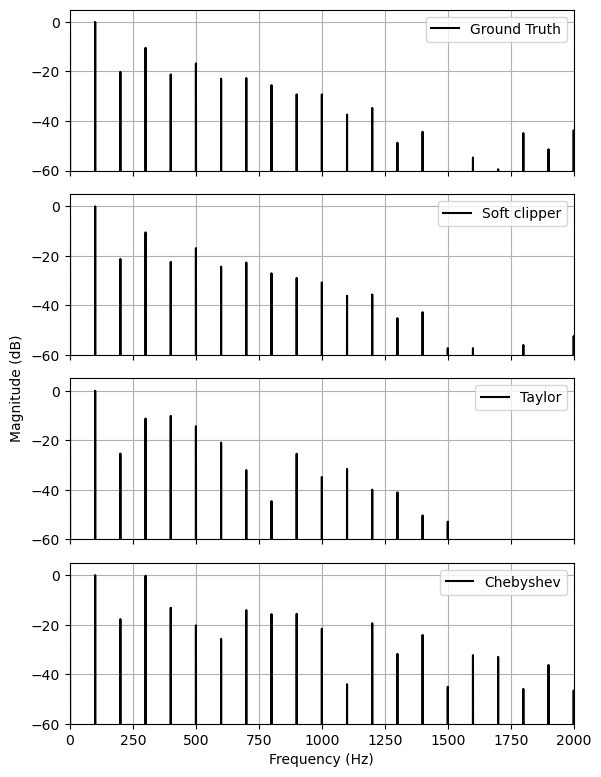

In [79]:

compute=True
export= True
exports={}

f0 = 100
if compute:

    x=x.to('cpu')


    outputs = {}

    with torch.no_grad():
        q = torch.rand(batch_size, SFX_chain.num_controls)
        q = torch.Tensor([[
            .8, .5, .8
        ]])

        imp = torch.arange(sr_hz).reshape(1, 1, sr_hz)
        imp = imp*torch.ones(batch_size, 1, 1)
        imp = torch.sin(imp/sr_hz*2*np.pi*f0)


        y = SFX_chain(x, q =q)
        
        outputs['Ground Truth'] = SFX_chain(imp, q =q).detach().cpu().numpy()
        
        exports['Input'] = x.clone().detach().cpu().numpy()
        exports['GT'] = y.clone().detach().cpu().numpy()

        x=x.to(device)
        y=y.to(device)
        imp=imp.to(device)

        for label, netAFX in netAFX_list.items():
            controller=netAFX['net']
            AFX_Chain=netAFX["fx"]
            qHat = controller(y)
            
            yHat = AFX_Chain(x, q =qHat)
            yHat = yHat/torch.sqrt(torch.mean(torch.square(yHat), axis=2, keepdim=True))
            exports[label] = yHat.detach().cpu().numpy()
            print(netAFX['label'])
            print(f'Mel metric: {round(torch.mean(Mel(y, yHat)).item(), 4)}')

            yHat = AFX_Chain(imp, q =qHat)
            yHat = yHat/torch.sqrt(torch.sum(torch.square(yHat), axis=2, keepdim=True))
            outputs[netAFX['label']] = yHat.detach().cpu().numpy()

max_val = 0
for label in exports.keys():
    exports[label] = exports[label]/RMS(exports[label])
    max_val = max(max_val, np.amax(np.abs(exports[label])))

for label in exports.keys():
    exports[label] = exports[label]/max_val

if export:
    for label, sig in exports.items():
        scipy.io.wavfile.write(filename=f'Exports/Distortion/{label}.wav', rate=44100, data=sig)

    
keys=list(outputs.keys())
fig, ax = plt.subplots(figsize = (15*cm, 20*cm), nrows=len(keys), ncols=1, sharex=True)

for idx in range(len(ax)):
    label=keys[idx]
    sig=outputs[label]

    sig = sig[0,0,:]
    sig=sig/RMS(sig)

    x_fft = np.fft.rfft(sig)
    x_fft = x_fft/np.amax(np.abs(x_fft))
    f = np.fft.rfftfreq(n=len(sig), d = 1/44100)


    line = ax[idx].plot(f, dB20(x_fft/RMS(sig)),styles[label], label = label)
    ax[idx].set_ylim(-60, 5)
    ax[idx].grid()
    ax[idx].legend()


#plt.semilogx()
plt.xlim(0, 2000)
plt.xlabel("Frequency (Hz)")
fig.text(-0.01, 0.5, 'Magnitude (dB)', va='center', rotation='vertical')
plt.tight_layout()
if export:
    plt.savefig("Exports/Distortion/Dist_Matching.svg")
plt.show()


    #plt.plot(q_np*30-15)
    #plt.plot(qHat_np*30-15)
    #plt.show()